In [25]:
import pandas as pd 
import numpy as np 
import re
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SVMSMOTE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pickle

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
def get_top_k_cluster_frequencies(df, groupby, cluster_column, k=5):
    """
    Returns the frequency of clusters grouped by groupby
    """
    batches = []
    df_group = df.groupby(groupby)
    df_group.apply(lambda x: batches.append(x[cluster_column].value_counts().head(k)))  #include_groups=False
    return batches


def get_appereances(freq_list):
    """
    Get the number of appereances of each cluster in all the lists
    """
    appereances = {}
    for batch in freq_list:
        for number in batch.index.values:
            if number in appereances.keys():
                appereances[number] += 1
            else:
                appereances[number] = 1
        # [appereances[number] += 1 for number in batch.index.values]
        # print(batch.index.values)
    return pd.Series(appereances)


def get_sentences_in_cluster(df, sentence_column, cluster_column, cluster):
    """
    Returns the tokens that are related to one cluster
    """
    return df[df[cluster_column] == cluster][sentence_column]


def get_training_matrix(df, df_norm, num_clusters):
    """
    Extract the features and generate a matrix with CVs as the rows and frequency of clusters as the columns.
    """
    print('Step::get_training_matrix')
    
    keys = df['index'].unique()
    print(len(keys))
    print(keys)
    X = {k: np.zeros(num_clusters+1) for k in keys}
    
    for _, row in df.iterrows():
        X[row['index']][row['cluster']] += 1

    for key, value in X.items():
        X[key][:-1] = X[key][:-1] / df_norm.iloc[key] if df_norm.iloc[key] != 0 else X[key][:-1]
        X[key][-1] = df_norm.iloc[key] / 100
    
    df_result = pd.DataFrame(X).T

    clusters_coeff, words_coeff = get_cidf_coefficients(df)
    clusters_features = np.array(get_clusters_features(df_result, clusters_coeff))
    words_features = np.array(get_individual_words_features(df, words_coeff))

    print('Cluster features')
    print(clusters_features.shape)
    print('Words features')
    print(words_features.shape)
    # Merge clusters_features and words_features together
    df_result = np.concatenate([clusters_features, words_features], axis=1)
    print('DfResult')
    print(df_result.shape)

    return df_result, clusters_coeff, words_coeff


def get_test_matrix(df, df_norm, num_clusters, clusters_coeff, words_coeff):
    """
    """
    keys = df['index'].unique()
    X = {k: np.zeros(num_clusters+1) for k in keys}
    
    for _, row in df.iterrows():
        X[row['index']][row['cluster']] += 1

    for key, value in X.items():
        X[key][:-1] = X[key][:-1] / df_norm.iloc[key] if df_norm.iloc[key] != 0 else X[key][:-1]
        X[key][-1] = df_norm.iloc[key] / 100
    
    df_result = pd.DataFrame(X).T

    clusters_features = np.array(get_clusters_features(df_result, clusters_coeff))
    words_features = np.array(get_individual_words_features(df, words_coeff))

    print('Cluster features')
    print(clusters_features.shape)
    print('Words features')
    print(words_features.shape)
    # Merge clusters_features and words_features together
    df_result = np.concatenate([clusters_features, words_features], axis=1)
    print('DfResult')
    print(df_result.shape)

    return df_result


def convert_embedding(embedding_str):
    embedding_str = embedding_str.strip('[]')
    if embedding_str[0] == ' ':
        embedding_str = embedding_str[1:]
    embedding_list = re.split(r'\s+', embedding_str)
    embedding_array = np.array([float(x) for x in embedding_list if x], dtype=float)
    return embedding_array


def get_clusters_features(df, clusters_coeff):
    """
    This function gets the features for the clusters
    """
    for column in df.columns:
        if str(column) in clusters_coeff.columns:
            df[column] *= clusters_coeff[str(column)].iloc[0]

    return df


def get_individual_words_features(df, words_coeff):
    """
    This function extract features
    """
    # We get the features for c_idf
    df_copy = df.copy()
    df_copy['combined_sentences'] = df.groupby('index')['sentence'].transform(lambda x: " ".join(x))
    corpus = df_copy.drop_duplicates(subset=['index', 'combined_sentences'])
    print('Corpus Shape')
    print(corpus.shape)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus['combined_sentences'])

    columns = vectorizer.get_feature_names_out()
    cols = words_coeff.columns
    print('Cols')
    print(cols)
    X = X.toarray()
    result = np.zeros((X.shape[0], words_coeff.shape[1]))
    for i, col in enumerate(cols):
        if col in columns:
            index = -1
            for it in range(len(columns)):
                if columns[it] == col:
                    index = it
                    break
            if index != -1:
                result[:, i] = (X[:, index] * words_coeff[col].iloc[0])

    return result

def get_cidf_coefficients(df):
    """
    This function gets the coefficients of the inverse class frequencies for
    clusters and for words

        Parameters:
            dataframe with clusters and sentences

        Return:
            (cluster_coeff, words_coeff) -> Pandas dataframes with the values
            of the coefficients of the inverse class frequency
    """
    # We get the c_idf (inverse class document frequency for the clusters)
    documents = []
    df.groupby('label').apply(lambda x: documents.append(x['cluster'].to_list()), include_groups=False)
    docs = []
    for document in documents:
        docs.append(' '.join(str(x) for x in document))

    clusters_coeff = c_idf(docs)

    # We get the c_idf (inverse class document frequency for the words)
    documents = []
    df.groupby('label').apply(lambda x: documents.append(x['sentence'].to_list()), include_groups=False)
    docs = []
    for document in documents:
        docs.append(' '.join(str(x) for x in document))

    words_coeff = c_idf(docs)

    return clusters_coeff, words_coeff


def c_idf(docs):
    """
    This function calculates the class inverse document frequency following the
    formula:

    c_idf = ln(1 + A/fx)

    Where:
    A: Average number of words per class
    fx: Frequency of word x across all classes

        Parameters:
            list of documents in str format
        
        Return:
            Vector with the inverse frequencies
    """
    # Initialize document frequency and average
    df, avg = 0, 0

    df = {}
    for document in docs:
        words = document.split(" ")
        avg += len(words)
        for word in words:
            if word in df:
                df[word] += 1
            else:
                df[word] = 1

    avg /= len(docs)

    cidf = {}
    for key, value in df.items():
        cidf[key] = np.log(1 + avg/value)

    cidf = pd.DataFrame(cidf, index=[0])
    
    return cidf


def generate(df, labels, reqs, start_value=100000):
    """
    This function generates data using the requirements (reqs)
    """
    print('Step::generate()')
    gen_features = df.copy()
    gen_labels = labels.copy()
    max_index = df['index'].max() + start_value
    print(f'generate::max_index: {max_index}')

    for key, value in reqs.items():
        mean_size = round(df[df['label'] == key]['len'].mean())
        
        gen_labels = pd.concat([gen_labels, pd.Series([key]*value)])

        # We need to get the mean and variance of each component of the embeddings
        embeddings = np.array(df[df['label'] == key]['embedding'].to_list())
        means = np.mean(embeddings, axis=0)
        std = np.std(embeddings, axis=0)
        
        for i in range(value):
            new_df = df[df['label'] == key].sample(mean_size)[['sentence', 'embedding']].copy()

            noise = np.random.normal(loc=means, scale=std, size=(mean_size,384))
            # print('EMBDS')
            # print(embds.shape)
            # print(noise.shape)

            # synt_embds = embds + noise
            synt_embds = pd.Series(noise.tolist())
            # print('Syth Embds')
            # print(synt_embds.shape)
            
            new_df['embedding'] = synt_embds.values
            new_df.insert(0, column='index', value=max_index)
            new_df.insert(0, column='label', value=key)
            new_df['len'] = mean_size
            gen_features = pd.concat([gen_features, new_df], axis=0)
            max_index += 1
        
        # Create a corpus of sentence, colum
        # print(f'Mean Size: {mean_size}')
        # print(f'Max Value: {max_index}')
        # print(result)
    print(max_index)
    return gen_features, gen_labels


def generate_synth_data(df_embeddings, df_cvs, n_samples=100):
    """
    This function generates synthetic data

        Parameters:
            df ->
            n_samples -> All the classes that have lower samples than n_samples
            will generate data up to n_samples
    """
    samples = df_cvs.groupby('label').count()['index']
    sizes = df_embeddings.groupby('label')['len'].mean()
    print(sizes)
    reqs = {}
    for index, value in samples.items():
        print(index, value)
        reqs[index] = max(0, n_samples - value)
    print(reqs)

    new_features, new_labels = generate(df_embeddings, df_cvs['label'], reqs)
    return new_features, new_labels


def create_model(df_embeddings, df_cvs, train_index, classifier, n_clusters=30):
    """
    This function trains a model with the df received as input and returns a model as output
    """
    # We get the clusters for this dataframe
    print('Step 1:: Getting DataFrames')
    X_train = df_embeddings[df_embeddings['index'].isin(train_index)].copy()
    print(f'XTRAIINNNNN: {len(X_train['index'].unique())}')
    y_train = df_cvs[df_cvs['index'].isin(train_index)].copy()['label']
    print(f'Y_TRAINNNNNN: {y_train.shape}')
    print('y_train labels')
    print(y_train.unique())
    df_cvs_copy = df_cvs[df_cvs['index'].isin(train_index)].copy()

    print('Step 2:: Generating Synthetic Data')
    rows_gerente = round(df_cvs_copy[df_cvs_copy['label'] == 'Gerente'].shape[0])
    print(f'Rows Gerente:: {rows_gerente}')
    X_train, y_train = generate_synth_data(X_train, df_cvs_copy, rows_gerente)
    print(f'X_train.shape:: {X_train.shape}')
    print(f'y_train.shape:: {y_train.shape}')
    print(f'create_model::CVs in X_train: {X_train['index'].unique().shape}')
    
    print('Step 3:: Applying Kmeans')
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=5).fit(X_train['embedding'].to_list())
    X_train['cluster'] = kmeans.labels_

    # Create model to predict kmeans
    print('Step 4:: Create model to predict Kmeans')
    train = np.array(X_train['embedding'].to_list())
    y = kmeans.labels_

    clf_clusters = LogisticRegression(class_weight='balanced')
    clf_clusters.fit(train, y)
    print(f'Score logistic regression: {balanced_accuracy_score(y, clf_clusters.predict(train))}')
    
    # We convert the dataframe for training and remove the values that are not in train_index
    print('Step 5:: Get Training Matrix')
    X, clusters_coeff, words_coeff = get_training_matrix(X_train, X_train['len'], n_clusters)
    # smote = SVMSMOTE(random_state=123)
    # X, y_train = smote.fit_resample(X, y_train)
    print(f'X.shape:: {X.shape}')

    ## Aqui se deberian generar los nuevos datos sintenticos con X
    print('Step 6::PCA')
    pca = decomposition.PCA(n_components=300)
    pca.fit(X)
    X = pca.transform(X)
    print('Shape After pca')
    print(X.shape)

    X_pro = X

    # We apply LDA
    print('Step 8::Apply LDA')
    print(f'X_pro.shape:: {X_pro.shape}')
    print(f'y_train.shape:: {y_train.shape}')
    print(X_pro)
    print(y_train.unique())
    clf = LDA()
    lda_model = clf.fit(np.array(X_pro), y_train)
    X_points = lda_model.transform(np.array(X_pro))

    # Train the classifier
    print('Step 9:: Train Classifier')
    print(X_points)
    print(f'X_points.shape:: {X_points.shape}')
    print(f'y_trian.shape:: {y_train.shape}')
    clf_model = classifier.fit(X_points, y_train)
    np.savetxt('X_points3.csv', X_points, delimiter=",")
    y_train.to_csv('y_train3.csv', index=False)
    return kmeans, lda_model, clf_model, clf_clusters, pca, 3, clusters_coeff, words_coeff


def test_model(df_embeddings, df_cvs, test_index, kmeans, lda_model, clf_model, clf_clusters, pca, mask, n_clusters, clusters_coeff, words_coeff):
    """
    This function evaluates a model
    """
    X_test = df_embeddings[df_embeddings['index'].isin(test_index)].copy()
    y_test = df_cvs[df_cvs['index'].isin(test_index)].copy()['label']
    df_cvs_copy = df_cvs[df_cvs['index'].isin(test_index)].copy()

    print('Step 2:: Generating Synthetic Data')
    rows_gerente = df_cvs_copy[df_cvs_copy['label'] == 'Gerente'].shape[0]
    print(f'Rows Gerente:: {rows_gerente}')
    # X_test, y_test = generate_synth_data(X_test, df_cvs_copy, rows_gerente)
    # kmeans_prediction = kmeans.predict(X_test['embedding'].to_list())
    # X_test['cluster'] = kmeans_prediction

    cluster_prediction = clf_clusters.predict(X_test['embedding'].to_list())
    X_test['cluster'] = cluster_prediction

    # We convert the dataframe for training and remove the values that are not in train_index
    X = get_test_matrix(X_test, X_test['len'], n_clusters, clusters_coeff, words_coeff)

    print('Step::Apply PCA')
    X = pca.transform(X)

    print('Step::Apply mask')
    X_pro = X
    # X_points = np.array(X_pro)
    # X_pro = X

    # We apply LDA
    print('Step::Apply LDA')
    X_points = lda_model.transform(np.array(X_pro))
    # X_points = X_pro
    
    # target_names = np.array([0, 1, 2])
    # for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    #     plt.scatter(X_points[y_test == i, 0], X_points[y_test == i, 1], c=c, label=target_name)
    #     plt.legend()
    #     plt.title('LDA')
    
    # plt.show()

    # Test the classifier
    # print('#################################################')
    # print('Real Ground Values:')
    # print(y_test)
    # print('Predict Values')
    # print(clf_model.predict_proba(X_points))
    # print(clf_model.predict(X_points))
    # score = clf_model.score(X_points, y_test)
    np.savetxt('X_points_test3.csv', X_points, delimiter=",")
    y_test.to_csv('y_test_test3.csv', index=False)
    print('Step::10 Predict Proba')
    print(y_test)
    print(clf_model.predict_proba(X_points))
    score = balanced_accuracy_score(y_test, clf_model.predict(X_points))
    cm = confusion_matrix(y_test, clf_model.predict(X_points), labels=clf_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_model.classes_)
    disp.plot()
    plt.show()
    return score

In [28]:
df_embeddings = pd.read_excel('D:/Github/CVClassifier/data/output_5.xlsx', sheet_name='Embeddings')
df_cvs = pd.read_excel('D:/Github/CVClassifier/data/output_5.xlsx', sheet_name='CVs')

In [29]:
len(df_cvs[df_cvs['label'] == 'Director'])

441

In [30]:
len(df_embeddings['index'].unique())

2451

In [31]:
len(df_cvs['index'].unique())

2451

In [32]:
print('Embeddings:')
display(df_embeddings.head())
print(df_embeddings.shape)
print(df_embeddings.dtypes)

print('CVs:')
display(df_cvs.head())
print(df_cvs.shape)
print(df_cvs.dtypes)

Embeddings:


,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,[-4.47424054e-02 2.24276166e-02 5.02501056e-...,57
1,Gerente,0,o id na project implementation emphasis manage...,[-2.00967677e-02 5.39981909e-02 -2.66174022e-...,57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,[-3.60780656e-02 -1.95347006e-03 -3.81188877e-...,57
3,Gerente,0,address diagonal house mail hot mail understan...,[-7.89540994e-04 1.34884324e-02 5.60681103e-...,57
4,Gerente,0,customer need decision making conflict resolut...,[-3.67572196e-02 1.91883203e-02 1.27373321e-...,57


(105168, 5)
label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object
CVs:


,label,index,text
0,Gerente,0,leader experience supply chain quality leaders...
1,Gerente,1,profile chemical engineer experience project m...
2,Gerente,2,yahoo cell graduate public accounting speciali...
3,Gerente,3,mechanical electrical engineer contact rel coa...
4,Gerente,4,environmental health safety manager risk manag...


(2451, 3)
label    object
index     int64
text     object
dtype: object


In [33]:
df = df_embeddings.copy()
df['embedding'] =df['embedding'].apply(convert_embedding)
display(df.head())
print(df_embeddings.dtypes)

,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,"[-0.0447424054, 0.0224276166, 0.0502501056, 0....",57
1,Gerente,0,o id na project implementation emphasis manage...,"[-0.0200967677, 0.0539981909, -0.0266174022, -...",57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,"[-0.0360780656, -0.00195347006, -0.0381188877,...",57
3,Gerente,0,address diagonal house mail hot mail understan...,"[-0.000789540994, 0.0134884324, 0.00560681103,...",57
4,Gerente,0,customer need decision making conflict resolut...,"[-0.0367572196, 0.0191883203, 0.00127373321, -...",57


label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object


In [34]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(df_cvs['label'])
print(y.shape)
y

(2451,)


array([2, 2, 2, ..., 1, 1, 1])

Test 0
Test indexes 246
Test indexes 2205
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         163   163
Step 1:: Getting DataFrames
XTRAIINNNNN: 2205
Y_TRAINNNNNN: (2205,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1459
label
Director       95.93
Especialista   29.06
Gerente        59.22
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1459
{'Director': 1062, 'Especialista': 1110, 'Gerente': 0}
Step::generate()
generate::max_index: 102464
104636
X_train.shape:: (228641, 5)
y_train.shape:: (4377,)
create_model::CVs in X_train: (4377,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9721139929800802
Step 5:: Get Training Matrix
Step::get_training_matrix
4377
[     0      1      2 ... 104633 104634 104635]
Corpus Shape
(4377, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire', 'doc', 'python', 

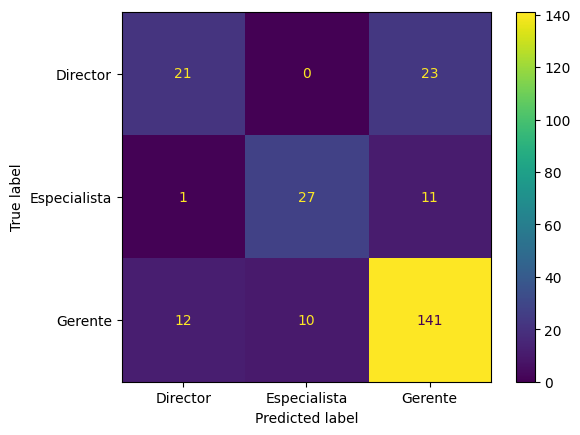

0.6782036981423484
Test 1
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     38    38
Gerente         163   163
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1459
label
Director       99.85
Especialista   28.89
Gerente        58.37
Name: len, dtype: float64
Director 397
Especialista 350
Gerente 1459
{'Director': 1062, 'Especialista': 1109, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104636
X_train.shape:: (233020, 5)
y_train.shape:: (4377,)
create_model::CVs in X_train: (4377,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9724245274247991
Step 5:: Get Training Matrix
Step::get_training_matrix
4377
[     1      3      4 ... 104633 104634 104635]
Corpus Shape
(4377, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire'

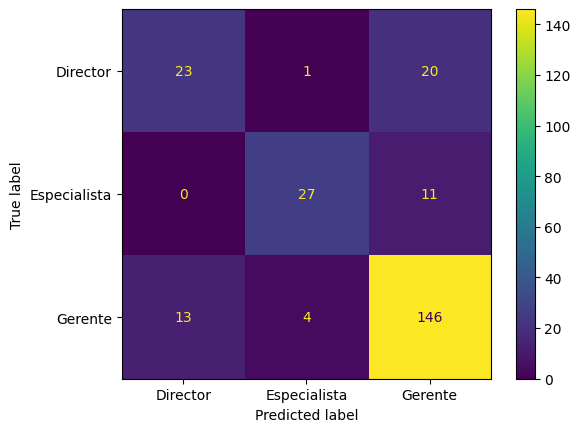

0.7096530366630464
Test 2
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         45    45
Especialista     38    38
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       97.47
Especialista   29.12
Gerente        58.27
Name: len, dtype: float64
Director 396
Especialista 350
Gerente 1460
{'Director': 1064, 'Especialista': 1110, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (228974, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9718506187757779
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire'

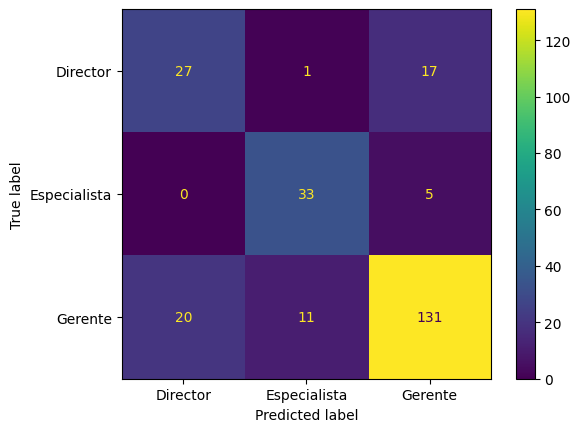

0.759021009313407
Test 3
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       98.69
Especialista   28.67
Gerente        59.99
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (232971, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9708005561840881
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire',

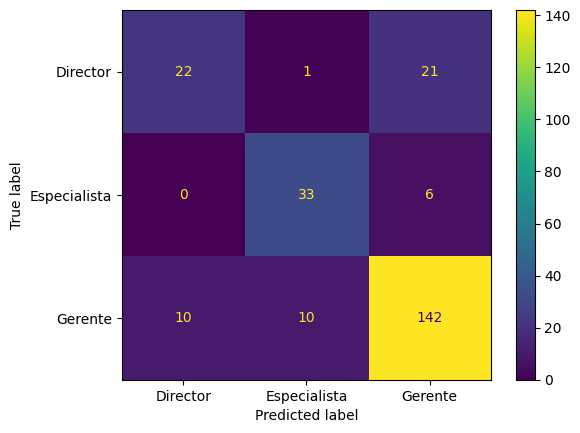

0.7408990186767964
Test 4
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       97.40
Especialista   27.97
Gerente        59.09
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (228355, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9666776205260018
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire'

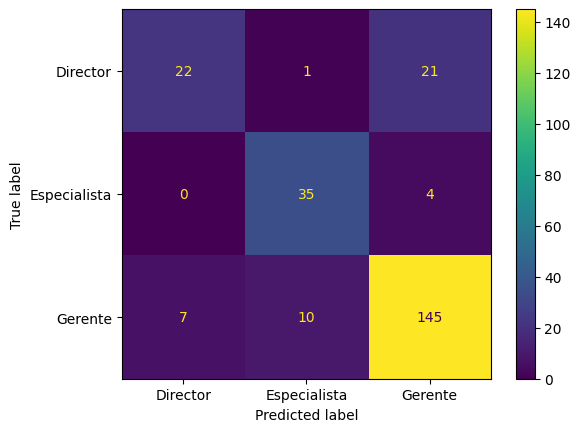

0.7641658752769863
Test 5
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       94.91
Especialista   28.47
Gerente        58.87
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (226475, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9749714638382827
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire'

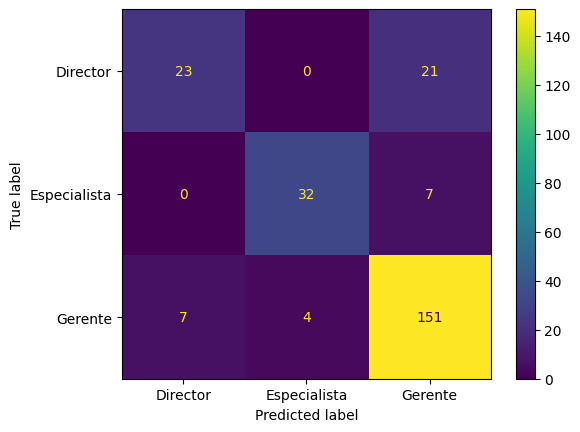

0.7584462862240641
Test 6
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       96.67
Especialista   29.23
Gerente        59.55
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (229696, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.971254279658368
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire',

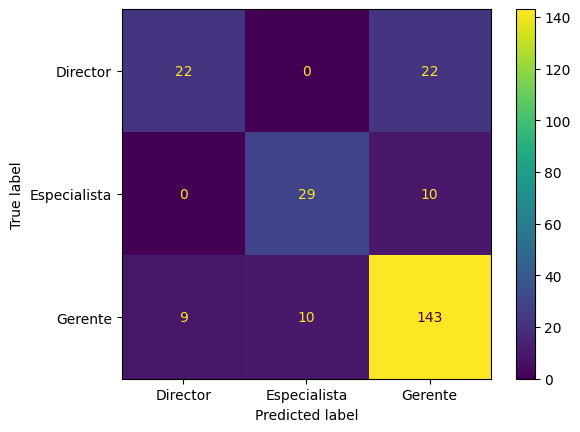

0.7087685976574866
Test 7
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       100.83
Especialista    29.16
Gerente         59.90
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (235576, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9717032806231546
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      2      3 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spi

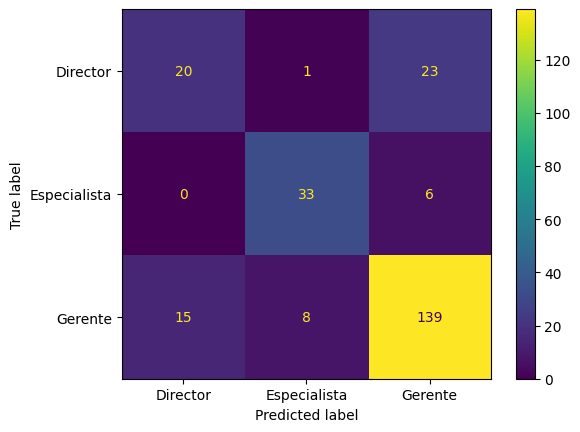

0.7195746640191084
Test 8
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       99.35
Especialista   28.85
Gerente        58.45
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (232014, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9676304891859976
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['contact', 'mela', 'brink', 'top', 'consumer

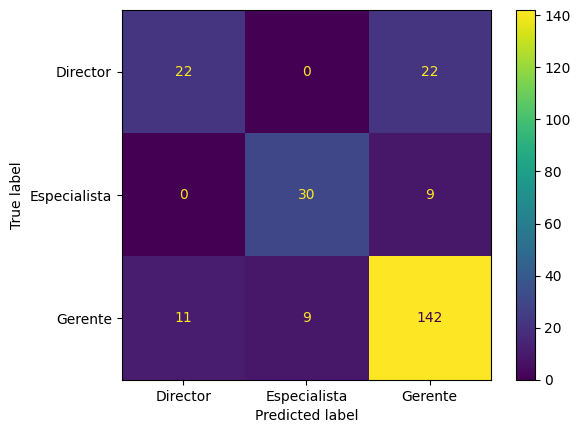

0.7152579930357708
Test 9
Test indexes 245
Test indexes 2206
              index  text
label                    
Director         44    44
Especialista     39    39
Gerente         162   162
Step 1:: Getting DataFrames
XTRAIINNNNN: 2206
Y_TRAINNNNNN: (2206,)
y_train labels
['Gerente' 'Director' 'Especialista']
Step 2:: Generating Synthetic Data
Rows Gerente:: 1460
label
Director       97.92
Especialista   29.13
Gerente        59.15
Name: len, dtype: float64
Director 397
Especialista 349
Gerente 1460
{'Director': 1063, 'Especialista': 1111, 'Gerente': 0}
Step::generate()
generate::max_index: 102465
104639
X_train.shape:: (231220, 5)
y_train.shape:: (4380,)
create_model::CVs in X_train: (4380,)
Step 3:: Applying Kmeans
Step 4:: Create model to predict Kmeans
Score logistic regression: 0.9726098026616573
Step 5:: Get Training Matrix
Step::get_training_matrix
4380
[     0      1      2 ... 104636 104637 104638]
Corpus Shape
(4380, 7)
Cols
Index(['evaluation', 'warning', 'document', 'spire'

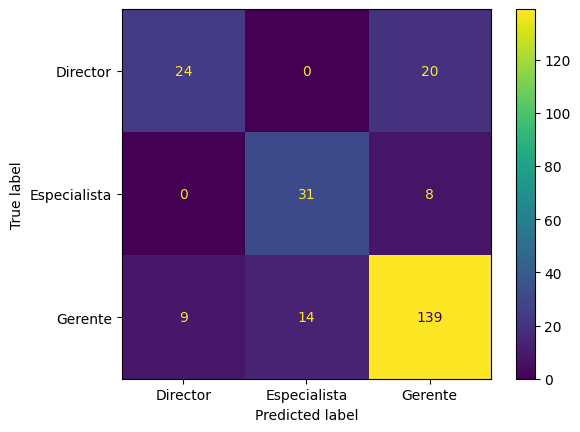

0.7327836772281217
Mean Score
0.7286773856237136


16           Gerente
22           Gerente
23           Gerente
61           Gerente
67           Gerente
            ...     
2391    Especialista
2394    Especialista
2404    Especialista
2412    Especialista
2433    Especialista
Name: label, Length: 244, dtype: object

In [35]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True)

indexes = df_cvs['index']
labels = df_cvs['label']

mean_score = 0
for i, (train_index, test_index) in enumerate(skf.split(indexes, labels)):
    print(f'Test {i}')
    # print(indexes.iloc[test_index])
    # # print(test_index)
    # print(df_cvs[df_cvs['index'].isin(test_idx)]['label'].unique())
    train_idx = indexes.iloc[train_index]
    test_idx = indexes.iloc[test_index]
    # break
    # print(len(df[df['index'].isin(train_idx)]['index'].unique()))
    # print(f'Len of train_index: {len(train_index)}')
    # print(f'Len of test_index: {len(test_index)}')
    print(f'Test indexes {len(test_idx)}')
    print(f'Test indexes {len(train_idx)}')
    print(df_cvs[df_cvs['index'].isin(test_idx)].groupby('label').count())
    kmeans, lda_model, clf_model, clf_clusters, pca, mask, clusters_coeff, words_coeff = create_model(df, df_cvs, train_idx, GradientBoostingClassifier(), n_clusters=30)
    
    # Save the models for later 
    with open('kmeans.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    with open('lda.pkl', 'wb') as f:
        pickle.dump(lda_model, f)

    with open('clf_model.pkl', 'wb') as f:
        pickle.dump(clf_model, f)

    with open('clf_clusters.pkl', 'wb') as f:
        pickle.dump(clf_clusters, f)

    with open('pca.pkl', 'wb') as f:
        pickle.dump(pca, f)

    clusters_coeff.to_csv('clusters_coeff.csv')
    words_coeff.to_csv('words_coeff.csv')

    score = test_model(df, df_cvs, test_idx, kmeans=kmeans, lda_model=lda_model, clf_model=clf_model, pca=pca, mask=mask, clf_clusters=clf_clusters, n_clusters=30, clusters_coeff=clusters_coeff, words_coeff=words_coeff)
    
    print(score)
    mean_score += score
    

print('Mean Score')
print(mean_score/10)
df_cvs[df_cvs['index'].isin(test_index)]['label']